In [1]:
!wget "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"

--2023-04-10 01:26:45--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 13.249.85.51, 13.249.85.110, 13.249.85.53, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|13.249.85.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  74.7MB/s    in 4.5s    

2023-04-10 01:26:50 (74.1 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [2]:
!unzip cell_images -d /content

Streaming output truncated to the last 5000 lines.
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
 extracting: /content/cell_images/Uninfected/C236

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
import scipy  #Used to upsample our image

import os
import cv2
from PIL import Image
import numpy as np


In [5]:
#############################################################################
# making a set of dataset containing 500 Uninfected and 500 Parasitized
import os
import random
import shutil
!mkdir cell_images/imagesUnif
source = 'cell_images/Uninfected'
dest = 'cell_images/imagesUnif'
files = os.listdir(source)
no_of_files = len(files) - 500

for file_name in random.sample(files, no_of_files):
    shutil.move(os.path.join(source, file_name), dest)

!mkdir cell_images/imagesPar
source = 'cell_images/Parasitized'
dest = 'cell_images/imagesPar'
files = os.listdir(source)
no_of_files = len(files) - 500

for file_name in random.sample(files, no_of_files):
    shutil.move(os.path.join(source, file_name), dest)

In [6]:
#Read images and get them ready for training

image_directory = 'cell_images/'
SIZE = 224
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Placeholders to define add labels. We will add 1 to all parasitized images and 0 to uninfected.

parasitized_images = os.listdir(image_directory + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

#Iterate through all images in Uninfected folder, resize to 224x224
#Then save into the same numpy array 'dataset' but with label 0

uninfected_images = os.listdir(image_directory + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

dataset = np.array(dataset)
label = np.array(label)

In [7]:
#Split into train and test data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

#Without scaling (normalize) the training may not converge. 
#so that all values are within the range of 0 and 1.

X_train = X_train /255.
X_test = X_test /255.


In [8]:
#Let us setup the model as multiclass with total classes as 2.
#This way the model can be used for other multiclass examples. 
#Since we will be using categorical cross entropy loss, we need to convert our Y values to categorical. 
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
#Define the model. 
#Here, we use pre-trained VGG16 layers and add GlobalAveragePooling and dense prediction layers.
#You can define any model. 
#Also, here we set the first few convolutional blocks as non-trainable and only train the last block.
#This is just to speed up the training. You can train all layers if you want. 
def get_model(input_shape = (224,224,3)):
    
    vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)

    #for layer in vgg.layers[:-8]:  #Set block4 and block5 to be trainable. 
    for layer in vgg.layers[:-5]:    #Set block5 trainable, all others as non-trainable
        print(layer.name)
        layer.trainable = False #All others as non-trainable.

    x = vgg.output
    x = GlobalAveragePooling2D()(x) #Use GlobalAveragePooling and NOT flatten. 
    x = Dense(2, activation="softmax")(x)  #We are defining this as multiclass problem. 

    model = Model(vgg.input, x)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
    
    return model 
model = get_model(input_shape = (SIZE,SIZE,3))
print(model.summary())    

58889256/58889256 [==============================] - 0s 0us/step


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv

In [10]:
history = model.fit(X_train, y_train, batch_size=16, epochs=30, verbose = 1, 
                    validation_data=(X_test,y_test))


Epoch 1/30
50/50 [==============================] - 19s 138ms/step - loss: 0.7169 - accuracy: 0.5175 - val_loss: 0.6703 - val_accuracy: 0.5500
Epoch 2/30
50/50 [==============================] - 5s 102ms/step - loss: 0.6834 - accuracy: 0.5400 - val_loss: 0.6452 - val_accuracy: 0.7300
Epoch 3/30
50/50 [==============================] - 5s 102ms/step - loss: 0.6047 - accuracy: 0.7163 - val_loss: 0.5481 - val_accuracy: 0.7450
Epoch 4/30
50/50 [==============================] - 5s 103ms/step - loss: 0.5516 - accuracy: 0.7462 - val_loss: 0.5394 - val_accuracy: 0.6950
Epoch 5/30
50/50 [==============================] - 5s 93ms/step - loss: 0.5238 - accuracy: 0.7563 - val_loss: 0.5828 - val_accuracy: 0.7450
Epoch 6/30
50/50 [==============================] - 5s 105ms/step - loss: 0.5189 - accuracy: 0.7575 - val_loss: 0.4950 - val_accuracy: 0.7700
Epoch 7/30
50/50 [==============================] - 5s 97ms/step - loss: 0.4515 - accuracy: 0.8100 - val_loss: 0.3674 - val_accuracy: 0.8700
Epoch 8

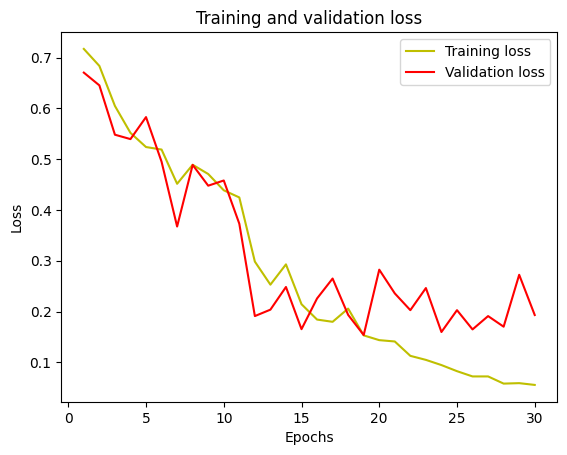

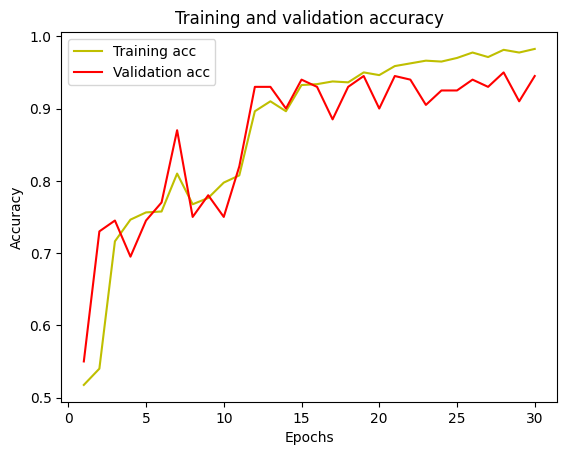

In [11]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
#Check model accuracy on the test data
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


7/7 [==============================] - 5s 113ms/step - loss: 0.1933 - accuracy: 0.9450
Accuracy =  94.49999928474426 %


1/1 [==============================] - 0s 29ms/step
The prediction for this image is:  1
The actual label for this image is:  1


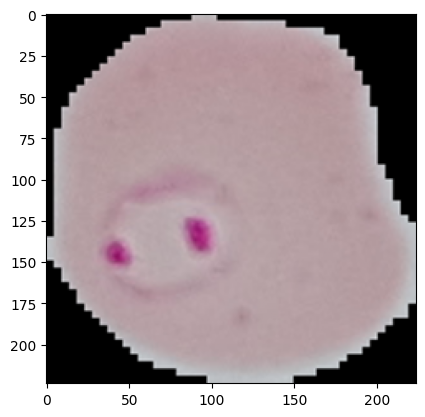

In [15]:
#Test on single image.
n=10  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))
print("The actual label for this image is: ", np.argmax(y_test[n]))


7/7 [==============================] - 1s 133ms/step


<Axes: >

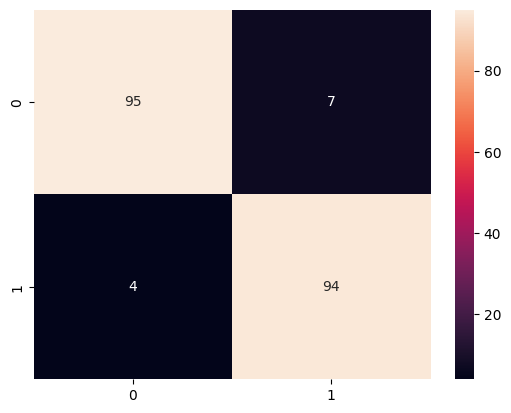

In [16]:
#Print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
cm=confusion_matrix(np.argmax(y_test, axis=1), y_pred)  
sns.heatmap(cm, annot=True)

In [17]:
#############################################################
#Save all images classified as parasited so we can fetch these images
#later and plot heatmaps.
########################################################
#Identify all images classified as parasitized
parasited_image_idx = np.where(y_pred == 1)[0]

In [18]:

#Save all images classified as parasited to a directory (optional, makes sense for large data sets)
#capture it in memory as an array
predicted_as_para=[]
for i in parasited_image_idx:
    par_img = X_test[i]
    #plt.imsave("results_classified_as_para/para_"+str(i)+".png", par_img)
    predicted_as_para.append(par_img)
    
predicted_as_para = np.array(predicted_as_para)    


In [19]:
from matplotlib.patches import Rectangle #To add a rectangle overlay to the image
from skimage.feature.peak import peak_local_max  #To detect hotspots in 2D images. 


In [54]:
def plot_heatmap(img):
  
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred)
    #Get weights for all classes from the prediction layer
    last_layer_weights = model.layers[-1].get_weights()[0] #Prediction layer
    #Get weights for the predicted class.
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]
    #Get output from the last conv. layer
    last_conv_model = Model(model.input, model.get_layer("block5_conv3").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
    last_conv_output = np.squeeze(last_conv_output)
    
    #Upsample/resize the last conv. output to same size as original image
    h = int(img.shape[0]/last_conv_output.shape[0])
    w = int(img.shape[1]/last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    
    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 512)), 
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    
    #Since we have a lot of dark pixels where the edges may be thought of as 
    #high anomaly, let us drop all heat map values in this region to 0.
    #This is an optional step based on the image. 
    heat_map[img[:,:,0] == 0] = 0  #All dark pixels outside the object set to 0
    
    #Detect peaks (hot spots) in the heat map. We will set it to detect maximum 5 peaks.
    #with rel threshold of 0.5 (compared to the max peak). 
    peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10) 

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.30)
    for i in range(0,peak_coords.shape[0]):
        print(i)
        y = peak_coords[i,0]
        x = peak_coords[i,1]
        plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))

    


1/1 [==============================] - 1s 854ms/step
0


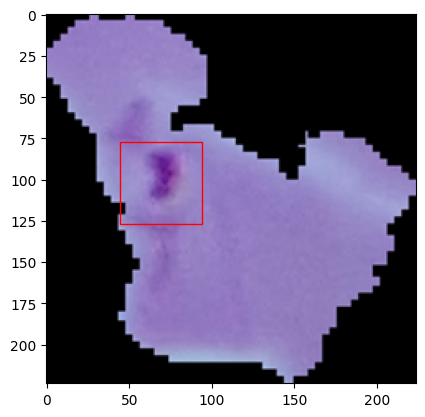

In [55]:
import random 
im = random.randint(0,predicted_as_para.shape[0]-1)
heat_map = plot_heatmap(predicted_as_para[im])

img = predicted_as_para[im]
plt.imshow(predicted_as_para[im])